In [1]:


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

from utils.visualization import visualize_target_distribution
from utils.pipeline import create_pipeline
from utils.util import (
    undump_ZV, get_cols_containing, get_columns_by_type, feature_importances_to_df, get_feature_to_keep,
    reduce_features, measure_performace, load_data
)
from utils.outliers import (
    count_values_above_threshold, count_values_below_threshold, remove_outliers
    )
from utils.feature_engineering import (
    apply_feature_engineering
)
from utils.constants import (
    target_column, DATA_PATH, DATA_FILE_NAME, MACRO_FILE_NAME,
    categorical_columns
)

# Кластеры для районов
# Таргет трайнуть

In [2]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
np.set_printoptions(threshold=np.inf)  # For NumPy arrays

In [3]:
raw_data_df, raw_macro_df = load_data(DATA_PATH, [DATA_FILE_NAME, MACRO_FILE_NAME])

In [4]:
# print(raw_macro_df.info())

In [5]:
# raw_data_df.head(1)

In [6]:
# raw_macro_df.head()

In [7]:
# raw_data_df = raw_data_df.merge(macro, on="timestamp", how="left")

In [8]:
raw_data_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [9]:
outliers_removed_df = remove_outliers(raw_data_df)

price_doc: 3014 rows
num_room: 6 rows
full_sq: 562 rows
life_sq: 628 rows
kitch_sq: 74 rows
build_year: 772 rows
kremlin_km: 1148 rows
area_m: 0 rows
max_floor: 46 rows
floor: 151 rows
full_all: 1108 rows
Processing 'green_part_500': Skewness = 2.22, Lower Bound: 0.0, Upper Bound: 86.86
Number of rows removed: 218 rows

Processing 'prom_part_500': Skewness = 3.12, Lower Bound: 0.0, Upper Bound: 56.47
Number of rows removed: 437 rows

Processing 'office_count_500': Skewness = 4.87, Lower Bound: 0.0, Upper Bound: 10.0
Number of rows removed: 551 rows

Processing 'office_sqm_500': Skewness = 4.33, Lower Bound: 0.0, Upper Bound: 171372.5000000022
Number of rows removed: 776 rows

Processing 'trc_count_500': Skewness = 2.82, Lower Bound: 0.0, Upper Bound: 6.0
Number of rows removed: 804 rows

Processing 'trc_sqm_500': Skewness = 5.43, Lower Bound: 0.0, Upper Bound: 467600.0
Number of rows removed: 886 rows

Processing 'cafe_count_500': Skewness = 5.62, Lower Bound: 0.0, Upper Bound: 71.0
Nu

Col_name: price_doc
Skewness: 0.6998906661401751
Upper_bound: 13400000.0
Dataset total rows: 20773
Number of rows > 13400000.0: 204
Number of NaN: 0
Col_name: price_doc
Number of rows < 20: 0


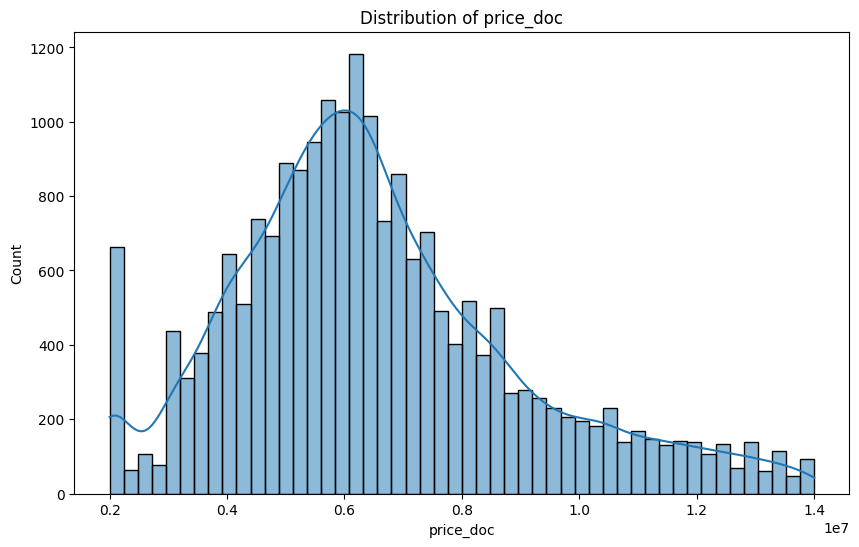

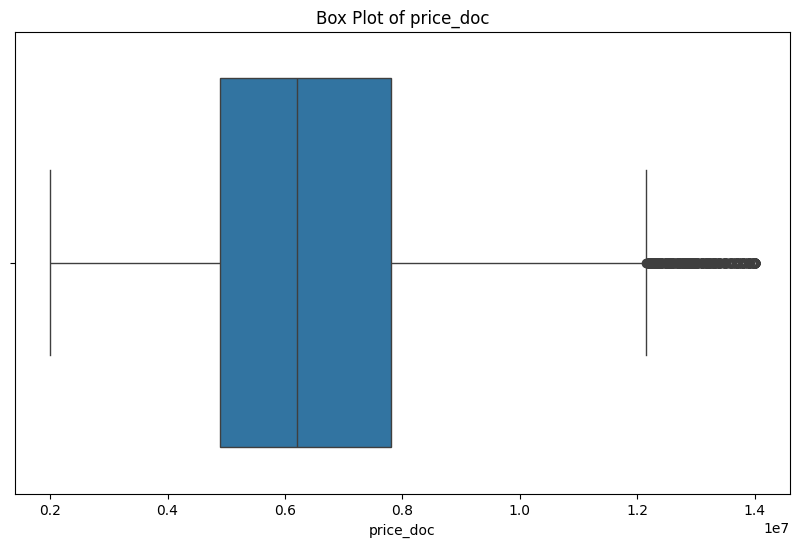

In [10]:
col_to_visualize = 'price_doc'
data_to_visualize = raw_data_df
data_to_visualize = outliers_removed_df
count_values_above_threshold(data_to_visualize, col_name=col_to_visualize)
count_values_below_threshold(data_to_visualize, col_to_visualize, 20)
visualize_target_distribution(data_to_visualize, col_to_visualize)

In [11]:
# data = Data_train
raw_data_df = outliers_removed_df

X = raw_data_df.drop(columns=[target_column])
y = raw_data_df[target_column]

In [12]:
df_cols = get_cols_containing(X, [
'university'
])
df_cols.head(1)

,university_top_20_raion,university_km
1,0,1.852560


In [13]:
X = apply_feature_engineering(X, y)


In [28]:
numerical_columns, _ = get_columns_by_type(X)
all_columns = categorical_columns + numerical_columns

print(len(X.columns))
print(len(categorical_columns))
print(len(numerical_columns))

85
15
70


In [15]:
preprocessing_pipeline = create_pipeline(
    all_columns=all_columns,
    numerical_columns=numerical_columns,
    include_scaling=False,
    include_knn_imputation=False,
    include_ecology_imputation=False
)

In [16]:
X_processed = preprocessing_pipeline.fit_transform(X, y)

In [17]:
# processed_pipeline = preprocessing_pipeline.fit(X, y)
# X_scaled = processed_pipeline.transform(X)
X_scaled = undump_ZV('X_scaled_for_DBSCAN_all_features')

In [18]:
# X_copy = X.copy()  # Create a copy of the original features
# if 'price_doc' not in X.columns:
#     X_copy['price_doc'] = y 

# # Step 2: Scale the target independently
# target_scaler = StandardScaler()
# price_doc_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# # Combine scaled features and target
# X_scaled_combined = np.hstack([X_scaled, price_doc_scaled])

In [19]:
# # Step 1: Dimensionality Reduction with PCA
# n_components = 50  # Reduce to 50 dimensions
# pca = PCA(n_components=n_components)
# X_reduced = pca.fit_transform(X_scaled_combined)  # PCA-transformed dataset

# # Step 2: Apply DBSCAN in PCA Space
# dbscan = DBSCAN(eps=15, min_samples=60)  # Adjust based on k-distance plot
# labels = dbscan.fit_predict(X_reduced)

# # Step 3: Map Outliers Back to Original Dataset
# outlier_indices = np.where(labels == -1)[0]  # Indices of outliers
# outliers_original = X_copy.iloc[outlier_indices]  # Outliers in the original dataset

In [20]:
# # Selected top 20 features for analytics
# top_20_features = [
#     'price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
#     'kitch_sq', 'state', 'kremlin_km', 'metro_km_walk', 'park_km', 'school_km', 
#     'kindergarten_km', 'shopping_centers_km', 'green_zone_km', 'railroad_station_walk_km', 
#     'industrial_km', 'cafe_count_500', 'market_count_500'
# ]

# # Analyze Outliers with the Top 20 Features
# outliers_top_features = outliers_original[top_20_features]

# # Print Outliers Information
# print(f"Outliers detected: {len(outlier_indices)}")
# print("Sample Outliers in Original Dataset (Top 20 Features):")
# outliers_top_features.head()


In [21]:
# # Step 4: Visualize Outliers in Original Features
# plt.figure(figsize=(10, 6))
# plt.scatter(X_copy['price_doc'], X_copy['full_sq'], c='gray', s=10, label='Normal Points')
# plt.scatter(outliers_original['price_doc'], outliers_original['full_sq'], c='red', s=20, label='Outliers')
# plt.title("Outliers in Original Dataset")
# plt.xlabel("Price (price_doc)")
# plt.ylabel("Size (full_sq)")
# plt.legend()
# plt.show()

In [22]:
# # Step 1: Fit NearestNeighbors on the dataset
# k = 60  # min_samples value or a smaller heuristic (e.g., 2 * n_components)
# neighbors = NearestNeighbors(n_neighbors=k)
# neighbors_fit = neighbors.fit(X_reduced)  # Use PCA-reduced dataset
# distances, _ = neighbors_fit.kneighbors(X_reduced)

# # Step 2: Sort distances for the k-th neighbor
# distances = np.sort(distances[:, -1])  # Sort the k-th nearest neighbor distances

# # Step 3: Plot the k-Distance Graph
# plt.figure(figsize=(10, 6))
# plt.plot(distances)
# plt.title("k-Distance Plot")
# plt.xlabel("Data Point Index (sorted)")
# plt.ylabel(f"{k}-Distance")
# plt.grid()
# plt.show()


In [23]:
# raise ValueError("This is a custom error message")

In [24]:
reduced_features = ['sub_area']
reduced_features = all_columns

X_reduced, features_reduced = reduce_features(X_processed, all_columns, reduced_features)

Reduced dimensionality: 85 → 85 (Rows: 20773)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [26]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

measure_performace(model, X_train, y_train, X_test, y_test)

Cross-Validated RMSE: 1552005.5163638936
Cross-Validated R^2 Score: 0.6067202091217041
Cross-Validated LRMSE: 0.29025903513765033

Test RMSE: 1463448.9271401071
Test R^2 Score: 0.6526361107826233
Test LRMSE: 0.2639416306529915

Test MSLE: 0.06966518439176016



In [27]:
model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)
model_fi.fit(X_train, y_train)
feature_importances_df = feature_importances_to_df(features_reduced, model_fi.feature_importances_)
features_to_keep = get_feature_to_keep(feature_importances_df, threshold = 0.01)

                                    Feature  Importance
Rank                                                   
1                                  sub_area    0.180073
2                                   full_sq    0.079854
3                                  num_room    0.036284
4                  cafe_total_affordability    0.027045
5                              product_type    0.018148
6                  cafe_total_accessibility    0.017454
7                   weighted_material_score    0.014088
8                                build_year    0.013739
9                     office_count_weighted    0.013009
10                             female_ratio    0.012810
11                               kremlin_km    0.012229
12                                    state    0.012139
13                     sport_count_weighted    0.012126
14                          ID_bus_terminal    0.012081
15                                  life_sq    0.011971
16                      office_sqm_weighted    0